In [10]:
from typing import Literal
from typing_extensions import TypedDict, List
import os 

# 서드파티 라이브러리
from dotenv import load_dotenv
from langchain_chroma import Chroma
from langgraph.graph import StateGraph, START, END, MessagesState
from pyzerox import zerox

# LangChain 관련 라이브러리
from langchain_core.documents import Document
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate,ChatPromptTemplate
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import (
    PyPDFLoader,
    UnstructuredMarkdownLoader,
    TextLoader,
)
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.tools import TavilySearchResults
from langchain_groq import ChatGroq
from langchain import hub
from langchain_core.runnables import RunnablePassthrough
import markdown
from bs4 import BeautifulSoup
from datetime import date
from pydantic import BaseModel, Field
from langgraph.prebuilt import tools_condition
load_dotenv()

True

In [2]:
MODEL_NAME = "gemma2-9b-it"

llm = ChatGroq(model_name=MODEL_NAME)
small_llm = ChatGroq(model_name=MODEL_NAME)
router_llm = ChatGroq(model_name=MODEL_NAME)


In [3]:
from langchain_community.tools import DuckDuckGoSearchRun

search_tool = DuckDuckGoSearchRun()

In [5]:
from langchain.agents import load_tools

loaded_tool_list = load_tools(
    ["arxiv"],
)

In [6]:
from langchain_core.tools.retriever import create_retriever_tool

In [7]:
embeddings_model = HuggingFaceEmbeddings(
    model_name='jhgan/ko-sroberta-nli',
    model_kwargs={'device':'cpu'},
    encode_kwargs={'normalize_embeddings':True},
)



#이미 생성된 크로마 db 가져오기
vector_store = Chroma(
    embedding_function=embeddings_model,
    collection_name = "income_tax_collection",
    persist_directory = "./income_tax_collection"
)

retriever = vector_store.as_retriever(search_kwargs = {"k":3})

retriever_tool = create_retriever_tool(
    retriever=retriever,
    name='real_estate_tax_retriever',
    description='Contains information about real estate tax up to December 2024',
)

C:\Users\user\AppData\Local\Temp\ipykernel_21476\730275842.py:1: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings_model = HuggingFaceEmbeddings(
c:\USERS\USER\DESKTOP\FINBRAINAGENT\VENV\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
from langgraph.prebuilt import ToolNode

tool_list = [ search_tool, retriever_tool]  + loaded_tool_list
llm_with_tools = small_llm.bind_tools(tool_list)
tool_node = ToolNode(tool_list)

In [11]:
def agent(state: MessagesState) -> MessagesState:
    messages = state['messages']
    response = llm_with_tools.invoke(messages)
    return {'messages': [response]}

In [12]:
graph_builder = StateGraph(MessagesState)

graph_builder.add_node('agent', agent)
graph_builder.add_node('tools', tool_node)

graph_builder.add_edge(START, 'agent')
graph_builder.add_conditional_edges(
    'agent',
    tools_condition
)
graph_builder.add_edge('tools', 'agent')

graph= graph_builder.compile()

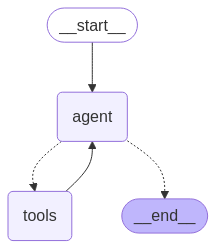

In [14]:
from IPython.display import Image, display

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [20]:
query = '집이 1000만원일때 종합부동산세 계산해줄수있냐'
graph.invoke({"messages":query})

{'messages': [HumanMessage(content='집이 1000만원일때 종합부동산세 계산해줄수있냐', additional_kwargs={}, response_metadata={}, id='16c9dcc2-ed41-49ae-a80d-a11142206cb9'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_c28z', 'function': {'arguments': '{"query":"종합부동산세 계산 1000만원"}', 'name': 'real_estate_tax_retriever'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 101, 'prompt_tokens': 1282, 'total_tokens': 1383, 'completion_time': 0.183636364, 'prompt_time': 0.04467853, 'queue_time': 0.022475627000000005, 'total_time': 0.228314894}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-049e0a38-a3be-4a90-9db6-fbf22f0ff542-0', tool_calls=[{'name': 'real_estate_tax_retriever', 'args': {'query': '종합부동산세 계산 1000만원'}, 'id': 'call_c28z', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1282, 'output_tokens': 101, 'total_tokens': 1383}),
  ToolMessage(content='제94조제1항제3호 및 목록

In [17]:
from langchain_core.messages import HumanMessage

query = '집이 1000만원일때 종합부동산세 계산해줄수있냐'
for chunk in graph.stream({'messages': [HumanMessage(query)]}, stream_mode='values'):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

집이 1000만원일때 종합부동산세 계산해줄수있냐
================================== Ai Message ==================================
Tool Calls:
  real_estate_tax_retriever (call_5b18)
 Call ID: call_5b18
  Args:
    query: 종합부동산세 계산 1000만원
================================= Tool Message =================================
Name: real_estate_tax_retriever

제94조제1항제3호 및 목록에 따른 자산 중 제104조의3에 따른 비사업용 토지의 보유 현황을 고려하여 대통령령으로 정하는 자산

소득세법
양도소득 과세표준
|       구간        |      세율       |
|:------------------:|:---------------:|
| 1,400만원 이하     |        16%      |
| 2,400만원 초과    | 22,204,000원 + (1,400만원 초과액 × 25% 세율) |
| 5,000만원 이하     | 1,124,000원 + (5,000만원 초과액 × 34% 세율) |
| 8,800만원 이하     | 5,206,000원 + (8,800만원 초과액 × 38% 세율) |
| 14,500만원 이하    | 5,206,000원 + (1,500만원 초과액 × 40% 세율) |
| 3,000만원 초과     | 12,406,000원 + (3,000만원 초과액 × 50% 세율) |
| 5,000만원 초과     | 12,406,000원 + (5,000만원 초과액 × 52% 세율) |
| 10,000만원 초과    | 48,406,000원 + (10억원 초과액

In [21]:
query = 'Chain of Thought 논문을 요약해라'
for chunk in graph.stream({'messages': [HumanMessage(query)]}, stream_mode='values'):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

Chain of Thought 논문을 요약해라
================================== Ai Message ==================================
Tool Calls:
  arxiv (call_rjsj)
 Call ID: call_rjsj
  Args:
    query: Chain of Thought Prompting
================================= Tool Message =================================
Name: arxiv

Published: 2023-01-10
Title: Chain-of-Thought Prompting Elicits Reasoning in Large Language Models
Authors: Jason Wei, Xuezhi Wang, Dale Schuurmans, Maarten Bosma, Brian Ichter, Fei Xia, Ed Chi, Quoc Le, Denny Zhou
Summary: We explore how generating a chain of thought -- a series of intermediate
reasoning steps -- significantly improves the ability of large language models
to perform complex reasoning. In particular, we show how such reasoning
abilities emerge naturally in sufficiently large language models via a simple
method called chain of thought prompting, where a few chain of thought
demonstrations are pro

In [22]:
query = '트럼프의 최근 관세 정책에 대해 알려줘'
for chunk in graph.stream({'messages': [HumanMessage(query)]}, stream_mode='values'):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

트럼프의 최근 관세 정책에 대해 알려줘
================================== Ai Message ==================================
Tool Calls:
  duckduckgo_search (call_tm2n)
 Call ID: call_tm2n
  Args:
    query: trump recent tariff policies
================================= Tool Message =================================
Name: duckduckgo_search

President Joe Biden largely preserves most of the tariffs Trump previously enacted against China, but his administration claims to take a more targeted approach.. In October 2022, he issues sweeping new restrictions on selling semiconductors and chipmaking equipment to China. These curbs will be expanded in October 2023 and December 2024 — when China responds with a ban of U.S. exports for ... NEW YORK (AP) — U.S. President Donald Trump's long-threatened tariffs are here, plunging the country into an escalating trade war with China, Canada and Mexico. Trump's 25% tariffs on imports from Can